In [154]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import torch
import torchvision.transforms as T
from torchvision.transforms import InterpolationMode

import numpy as np
from patchify import patchify,unpatchify
import PIL
import matplotlib.pyplot as plt
import os
import logging
import pickle as pk

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

logging.getLogger("PIL").setLevel(logging.WARNING)
logging.getLogger("matplotlib").setLevel(logging.WARNING)

PIL.Image.MAX_IMAGE_PIXELS = 933120000

import torch
from torch.utils.data import Dataset
import torchvision.transforms as T
from skimage.measure import block_reduce

In [3]:
def show_map(img):
    fig, ax = plt.subplots(figsize = (10,5))
    ax.imshow(img)
    plt.show()

In [4]:
def rotate_crop_map(map_img):
    gray = cv.cvtColor(map_img, cv.COLOR_RGB2GRAY)
    gray = 255 - gray
    thresh = cv.threshold(gray, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)[1]

    # Compute rotated bounding box
    coords = np.column_stack(np.where(thresh > 0))
    center_rect, dims, angle = cv.minAreaRect(coords)

    if angle < -45:
        angle = -angle
    else:
        angle = 90-angle
    print(angle)

    # Rotate image to deskew
    (h, w) = map_img.shape[:2]
    center = (w // 2, h // 2)
    M = cv.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv.warpAffine(map_img, M, (w, h), flags=cv.INTER_CUBIC, borderMode=cv.BORDER_REPLICATE)

    gray = cv.cvtColor(rotated, cv.COLOR_BGR2GRAY)
    gray = 255*(gray < 128).astype(np.uint8) # To invert the text to white
    coords = cv.findNonZero(gray) # Find all non-zero points (text)
    x, y, w, h = cv.boundingRect(coords) # Find minimum spanning bounding box
    rect = rotated[y:y+h, x:x+w] 
    rect = cv.cvtColor(rect, cv.COLOR_BGR2RGB)
    
    return rect

In [5]:
# transformations to apply to the map
def torch_downsample(img, kernel_size, interpolation = InterpolationMode.BILINEAR):
    size = img.shape
    
    new_size = (size[0]//kernel_size, size[1]//kernel_size)
    
    tensor_img = np.moveaxis(img, -1, 0)
    tensor_img = torch.Tensor(tensor_img)
    
    resized_map = T.Resize(new_size, interpolation=interpolation)(tensor_img)
    
    resized_map = resized_map.numpy()
    resized_map = np.moveaxis(resized_map, 0, -1)
    
    return resized_map.astype(int)

def bilinear_interpolator(img, kernel_size):
    return torch_downsample(img, kernel_size, interpolation = InterpolationMode.BILINEAR)

def bicubic_interpolator(img, kernel_size):
    return torch_downsample(img, kernel_size, interpolation = InterpolationMode.BICUBIC)

def bilinear_interpolator_4x4(img):
    return bilinear_interpolator(img, 4)

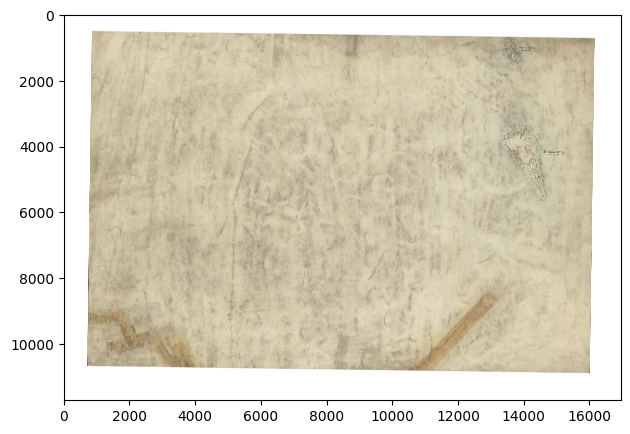

In [14]:
img = PIL.Image.open("../data/originals/82877139.27.tif")
show_map(bilinear_interpolator_4x4(np.array(img)))

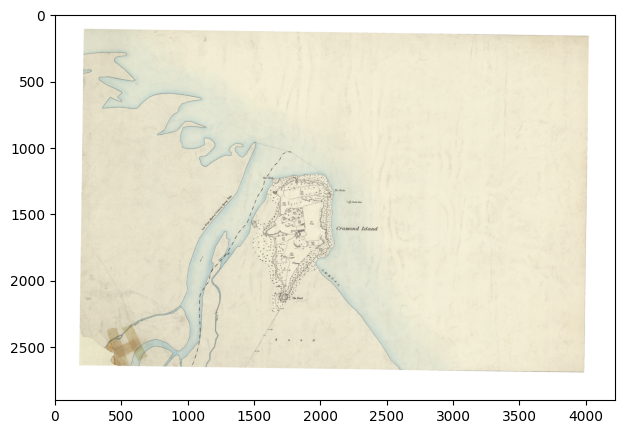

In [15]:
img = PIL.Image.open("../data/originals/82877145.27.tif")
show_map(bilinear_interpolator_4x4(np.array(img)))

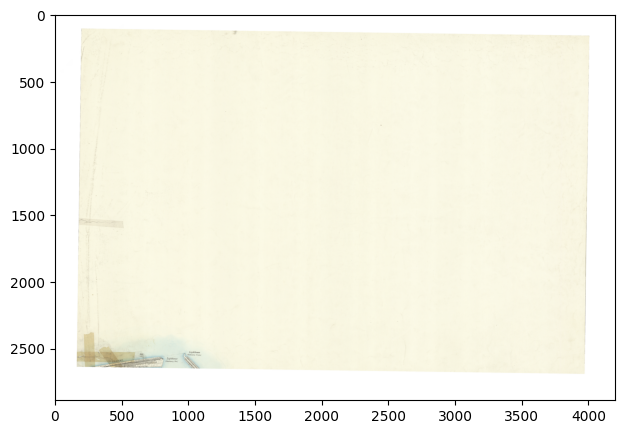

In [16]:
img = PIL.Image.open("../data/originals/82877154.27.tif")
show_map(bilinear_interpolator_4x4(np.array(img)))

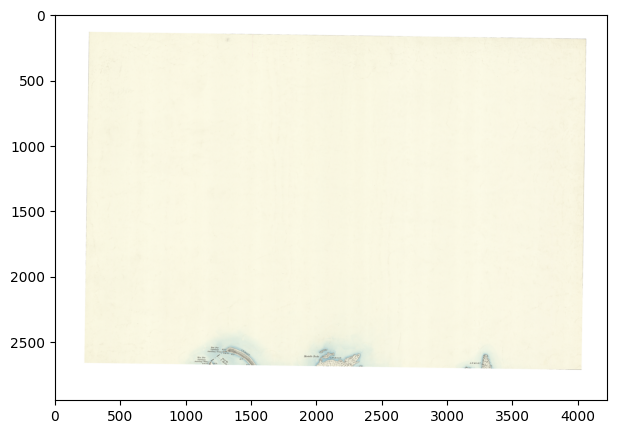

In [17]:
img = PIL.Image.open("../data/originals/82877166.27.tif")
show_map(bilinear_interpolator_4x4(np.array(img)))

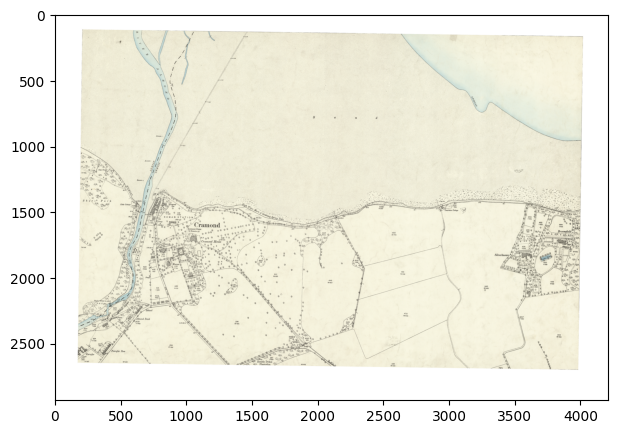

In [18]:
img = PIL.Image.open("../data/originals/82877178.27.tif")
show_map(bilinear_interpolator_4x4(np.array(img)))

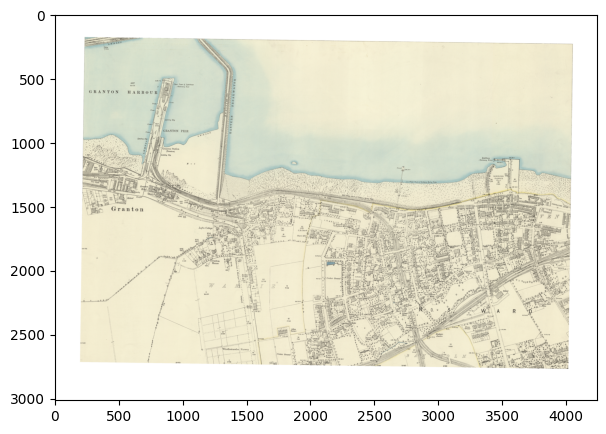

In [19]:
img = PIL.Image.open("../data/originals/82877202.27.tif")
show_map(bilinear_interpolator_4x4(np.array(img)))

In [2]:
img = PIL.Image.open("../data/originals/82877205.27.tif")

NameError: name 'show_map' is not defined

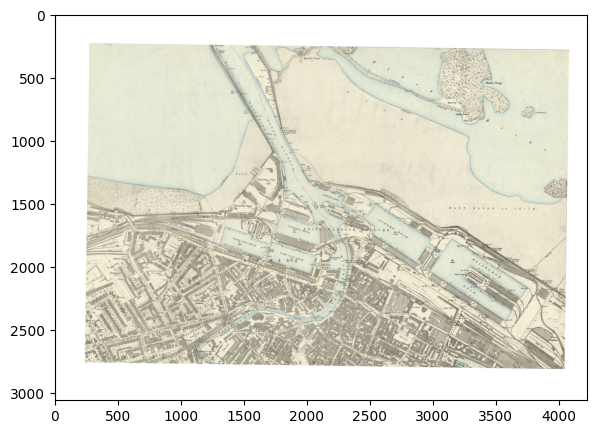

In [6]:
show_map(bilinear_interpolator_4x4(np.array(img)))

In [8]:
import rasterio
from pyproj import Transformer

In [11]:
img_map = rasterio.open("../data/originals/82877205.27.tif")
z = img_map.read()[0]

print(img_map.crs)

print(img_map.bounds)

EPSG:27700
BoundingBox(left=325650.9454718602, bottom=676010.5625622906, right=328332.4351353238, top=677950.2083216981)


In [12]:
import psycopg2 as psy

In [165]:
def get_map_bbox(file, to_long_lat = False):
    LONG_LAT_FORMAT = "EPSG:4326"
    img_map = rasterio.open(file)
    
    map_bbox = img_map.bounds
    
    top_left = (map_bbox.left, map_bbox.top)
    top_right = (map_bbox.right, map_bbox.top)
    bottom_right = (map_bbox.right, map_bbox.bottom)
    bottom_left = (map_bbox.left, map_bbox.bottom)
    
    map_name = file[file.rfind("/")+1 : -4]
    
    if to_long_lat:
        transformer = Transformer.from_crs(img_map.crs, LONG_LAT_FORMAT)

        conv_coords = lambda x: tuple(list(transformer.transform(*x))[::-1])

        return (map_name, 
                conv_coords(bottom_left), 
                conv_coords(bottom_right), 
                conv_coords(top_right), 
                conv_coords(top_left),
                to_long_lat)
    else:
        return (map_name,
                bottom_left,
                bottom_right,
                top_right,
                top_left,
                to_long_lat)

def bbox_to_sql(bbox):
    sql = "("
    for entry in bbox:
        if isinstance(entry, tuple):
            sql += f"'{entry}'::point,"
        else:
            sql += f"{entry},"
            
    sql = sql[:-1]
    sql += ")"
    
    return sql

def bbox_to_geojson(bbox):
    return f"""{{"type": "Feature",
    "properties": {{}},
    "geometry": {{
        "type": "Polygon",
        "coordinates": [[{list(bbox[-4])}, {list(bbox[-3])}, {list(bbox[-2])}, {list(bbox[-1])}, {list(bbox[-4])}]]
        }}
    }}"""

def write_db_map_bbox(directory, to_long_lat = False):
    bboxes = [get_map_bbox(f"{directory}/{file}", to_long_lat) for file in os.listdir(directory) if file.endswith("tif")]
    
    sql = """INSERT INTO map_bbox ("map_name", "bottom_left", "bottom_right", "top_right", "top_left", "is_long_lat")
    VALUES
    """
    
    for bbox in bboxes:
        sql += f"{bbox_to_sql(bbox)},\n"
    
    sql = sql.rstrip()
    sql = sql[:-1]
        
    conn = psy.connect(dbname = "honoursmap",
                   user = "",
                   host = "localhost",
                   port = 5432,
                   password = "")

    cursor = conn.cursor()

    cursor.execute(sql)

    conn.commit()

    cursor.close()
    conn.close()
    
    return bboxes

In [166]:
bboxes_ll = write_db_map_bbox("../data/originals/", to_long_lat = True)
bboxes = write_db_map_bbox("../data/originals/", to_long_lat = False)

In [189]:
from shapely.geometry import Polygon

In [220]:
def bbox_area_prop(bbox_1, bbox_2):
    p1 = Polygon(list(bbox_1))
    p2 = Polygon(list(bbox_2))
    p_intersect = p1.intersection(p2)
    
    area_bbox_1 = p1.area
    area_bbox_2 = p2.area
    area_bbox_intersect = p_intersect.area
    
    return (area_bbox_intersect/area_bbox_1, area_bbox_intersect/area_bbox_2)

def group_maps(directory, thresh = 0.7, to_long_lat = False):
    bboxes = [get_map_bbox(f"{directory}/{file}", to_long_lat) for file in os.listdir(directory) if file.endswith("tif")]
    groups = {}
    
    for bbox in bboxes:
        groups[bbox[0]] = []
        for bbox_ in bboxes:
            
            if bbox_[0] in groups:
                if bbox[0] in groups[bbox_[0]]:
                    groups.pop(bbox[0], None)
                    break
            
            if bbox_[0] != bbox[0]:
                if max(bbox_area_prop(tuple(list(bbox[1:-1])), tuple(list(bbox_[1:-1])))) >= thresh:
                    groups[bbox[0]].append(bbox_[0])
                   
    return groups

In [221]:
group_maps(directory)

{'82877178.27': [],
 '82877166.27': [],
 '82877412.27': ['82877418.27', '82877409.27', '82877415.27'],
 '82877139.27': [],
 '82877202.27': [],
 '82877154.27': [],
 '82877205.27': [],
 '82877184.27': [],
 '82877145.27': []}